In [ ]:
#Distinguere le categorie dataset, come?
#Nomi Features
#Numero o tipo features
#Metadati!
#Metodi di raccolta



# SynaptIA

## Carico il Json

In [20]:
#Test 

import json
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Carica i dati dal JSON
with open('export.json', 'r') as file:
    data = json.load(file)
   

## Normalizzazione

In [21]:
#FUNZIONE NORMALIZZAZIONE

import re
#from nltk.corpus import stopwords
import nltk

#stop_words = set(stopwords.words('english'))

#funzione che normalizza features: tutto lower + rimuove simboli strani
def normalize_feature(feature):
    # Rimozione di simboli strani e sostituzione degli spazi con underscore
    new_feature = re.sub(r'[^a-zA-Z_]', '', feature)
    # Sostituisci underscore con spazio
    new_feature = new_feature.replace('_', ' ')    
    
    # Inserisci spazio tra lettere maiuscole e minuscole
    new_feature = re.sub(r'([a-z])([A-Z])', r'\1 \2', new_feature)
    #gestisce caso 2 maiuscole
    new_feature = re.sub(r'([A-Z])([A-Z][a-z])', r'\1 \2', new_feature)
    
    # Trasformazione in minuscolo
    new_feature = new_feature.lower()
    #Rimuove eventuali spazi di troppo e iniziali finali
    new_feature = new_feature.strip()
    new_feature = re.sub(r'\s+', ' ', new_feature)
    return new_feature
       

In [22]:
#COSTRUZIONE STRINGA UNICA CON FEATURES SEPARATE DA SPAZIO:
#NORMALIZZATE (NO SIMBOLI STRANI E NUMERI, SEPARATI DA UNDERSCORE O LETTERA MAIUSCOLA-MINUSCOLA, POI RESI TUTTI MINUSCOLI)
#TOLTI I DOPPIONI
#SI LIMITA A PRIME N FEATURES, E A UNA LUNGHEZZA MASSIMA DELLA STRINGA TOTALE

#Limitazioni 
limit_len_s = 200 #lunghezza stringhe
limit_n_features = 20 #numero features

#il primo elemento nella lista è la categoria e viene tolta, le altre sono features
#features to string
set_features = []
categories = []

#exclude = ['age', 'gender', 'sex', 'id', 'value', 'height', 'weight']

for dataset in data:
    s = ""
    first_element_added = False  # per tenere traccia del primo elemento
    features_selected = data[dataset][0:limit_n_features] #prendo prime n features
    #applico normalizzazine
    for i in range(0, len(features_selected)):
        features_selected[i] = normalize_feature(features_selected[i])
    
    #rimuovo duplicati
    unique_elements = []
    seen = set()
    for el in features_selected:
        normalized = normalize_feature(el)
        if normalized not in seen:
            unique_elements.append(el)
            seen.add(normalized)   
    features_selected = unique_elements       
    #print(features_selected)
    for el in features_selected:
        if first_element_added:
            # Concatena gli elementi successivi fino a raggiungere 200 caratteri
            if len(s + el + " ") <= limit_len_s:
                #if el not in exclude:
                s = s + el + " "  # Concatena gli elementi successivi
            else:
                break  # Esci dal loop se la lunghezza supera i 200 caratteri
        else:
            categories.append(el)  # Aggiungi il primo elemento a categories
            first_element_added = True
            
    set_features.append(s.rstrip()) #Toglie spazio alla fine

    
#set_features[0:5]

In [23]:
#quante e quali categorie?
print(set(categories))

{'education', 'healthcare', 'music', 'sport'}


In [24]:
#DIZIONARIO COSTRUITO, SERVE PER CAPIRE SE STA FUNZIONANDO CON LE CATEGORIE CHE MI ATTENDO
#!! costruisco un dizionario con ciascuna stringa come chiave associata alla categoria. 
#!!costoso, da valutare se fare in un colpo solo prima
# Verifica se le liste hanno la stessa lunghezza
if len(categories) == len(set_features):
    dictionary = {}

    for i in range(len(categories)):
        stringa = set_features[i]
        categoria = categories[i]

        if stringa not in dictionary:
            dictionary[stringa] = categoria

    #print(dictionary)
else:
    print("Le liste non hanno la stessa lunghezza")


In [31]:
#esempio categories e set features se ho già
#import pandas as pd
#t = pd.read_csv('bbc-text.csv', encoding='latin1')
#categories = list(t['category'])
#set_features = list(t['text'])
    
    
#set_features = set_features[0:30]

## TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Quante features con tf idf più alto prendo?
len_mainfeatures = 5

# Creazione del vettore TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(set_features)

# Ottieni i nomi delle feature (termini)
feature_names = vectorizer.get_feature_names_out()

# Inizializza un vettore per i termini più significativi
top_terms = []
# Inizializzazione della lista per le stringhe con le 5 parole chiave per ogni documento
top_terms_strings = []

# Per ogni documento, identifica i primi n termini più significativi
for i, doc in enumerate(set_features):
    # Ottieni gli indici dei termini con TF-IDF più alto
    top_indices = tfidf_matrix[i].toarray().argsort()[0][::-1]
    # Filtra i termini con valore TF-IDF zero e prendi i primi tre
    nonzero_indices = [index for index in top_indices if tfidf_matrix[i, index] != 0][:len_mainfeatures]
    # Ottieni i termini e i relativi TF-IDF
    terms_tfidf = [(feature_names[index], tfidf_matrix[i, index]) for index in nonzero_indices]
    # Aggiungi i termini più significativi al vettore
    top_terms.append(terms_tfidf)

# Mostra i termini più significativi per ogni documento (stampa primi 5)
for i, terms in enumerate(top_terms[0:5]):
    print(f"Termini più significativi per il documento {i + 1}: " + categories[i])
    for term, tfidf_score in terms:
        print(f"- Termine: {term}, TF-IDF: {tfidf_score}")

# Ora puoi utilizzare la variabile top_terms che contiene i termini più significativi per ogni documento


Termini più significativi per il documento 1: education
- Termine: total, TF-IDF: 0.6353895564542043
- Termine: regents, TF-IDF: 0.3782074934334918
- Termine: cohort, TF-IDF: 0.3782074934334918
- Termine: num, TF-IDF: 0.34280982422093503
- Termine: pctofcohort, TF-IDF: 0.25213832895566124
Termini più significativi per il documento 2: education
- Termine: leveland, TF-IDF: 0.45754498252371334
- Termine: num, TF-IDF: 0.4147218597076986
- Termine: pct, TF-IDF: 0.4147218597076986
- Termine: level, TF-IDF: 0.3607711054093465
- Termine: tested, TF-IDF: 0.22877249126185667
Termini più significativi per il documento 3: education
- Termine: percent, TF-IDF: 0.5349114825253324
- Termine: frl, TF-IDF: 0.3183992071630475
- Termine: prek, TF-IDF: 0.3183992071630475
- Termine: fl, TF-IDF: 0.3183992071630475
- Termine: schoolyear, TF-IDF: 0.3183992071630475
Termini più significativi per il documento 4: education
- Termine: enrolled, TF-IDF: 0.4298949981624289
- Termine: absent, TF-IDF: 0.429894998162

In [27]:
# Inizializzazione della lista per le stringhe con le 5 parole chiave per ogni documento
top_terms_strings = []

# Creazione delle stringhe con le 5 parole chiave per ogni documento
for terms in top_terms:
    # Estrai le parole chiave e crea la stringa
    top_words = [term[0] for term in terms]
    top_words_string = ' '.join(top_words)
    top_terms_strings.append(top_words_string)

# Aggiungi il vettore delle stringhe con le parole chiave al vettore dei documenti
documents_with_top_words = list(zip(top_terms_strings, categories))

# Mostra i documenti con le parole chiave più significative
for i, (words, category) in enumerate(documents_with_top_words[0:10]):
    print(f"Documento {i + 1}: {words} - Categoria: {category}")

Documento 1: total regents cohort num pctofcohort - Categoria: education
Documento 2: leveland num pct level tested - Categoria: education
Documento 3: percent frl prek fl schoolyear - Categoria: education
Documento 4: enrolled absent present released dbn - Categoria: education
Documento 5: project phase name geographic building - Categoria: education
Documento 6: community nta bin bbl tract - Categoria: education
Documento 7: numberand street program census community - Categoria: education
Documento 8: score parent nr prep sport - Categoria: education
Documento 9: oosr primary age male female - Categoria: education
Documento 10: subject indicator index location time - Categoria: education


## LDA

In [28]:
#APPLICAZIONE LDA CON LE TOP TERMS DELLA LISTA FEATURES
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

# Preprocessing: creazione del dizionario
texts = [text.split() for text in top_terms_strings]
dictionary = corpora.Dictionary(texts)

# Rimuovere le parole molto frequenti o rare se necessario
# Ad esempio, per rimuovere le parole che appaiono in meno di 5 documenti o in più del 50% dei documenti:
#dictionary.filter_extremes(no_below=5, no_above=0.5)

# Creazione del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Creazione del modello LDA
num_categories = 4
lda_model = gensim.models.LdaModel(corpus, num_topics=num_categories, id2word=dictionary, passes=15)

# Stampare i topic e le parole chiave associate
for idx, topic in lda_model.print_topics(-1):
    print(f'Category: {idx} \nWords: {topic}\n')

# Per classificare un nuovo documento
new_doc = "player score time"
new_doc_bow = dictionary.doc2bow(word_tokenize(new_doc.lower()))
print(lda_model.get_document_topics(new_doc_bow))


Category: 0 
Words: 0.021*"date" + 0.012*"type" + 0.012*"released" + 0.012*"start" + 0.012*"of" + 0.012*"term" + 0.012*"variability" + 0.012*"rstatus" + 0.012*"per" + 0.012*"ys"

Category: 1 
Words: 0.017*"time" + 0.009*"num" + 0.009*"name" + 0.009*"male" + 0.009*"hip" + 0.009*"additional" + 0.009*"primary" + 0.009*"altname" + 0.009*"indie" + 0.009*"geom"

Category: 2 
Words: 0.016*"percent" + 0.016*"level" + 0.016*"spectral" + 0.016*"pct" + 0.016*"team" + 0.009*"id" + 0.009*"views" + 0.009*"score" + 0.009*"agestandardized" + 0.009*"dob"

Category: 3 
Words: 0.029*"medal" + 0.020*"country" + 0.020*"community" + 0.020*"games" + 0.020*"noc" + 0.020*"height" + 0.020*"season" + 0.011*"artist" + 0.011*"release" + 0.011*"national"

[(0, 0.06590117), (1, 0.3089824), (2, 0.56247216), (3, 0.06264427)]


In [37]:
set(categories)

{'business', 'entertainment', 'politics', 'sport', 'tech'}

## WORD2VEC

In [19]:
#WORD2VEC


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

model = api.load("word2vec-google-news-300")

## Clustering + PCA 2D

#### Cosine Similarity / Word2Vec Similarity

#### DBSCAN / K-Means / Gerarchico

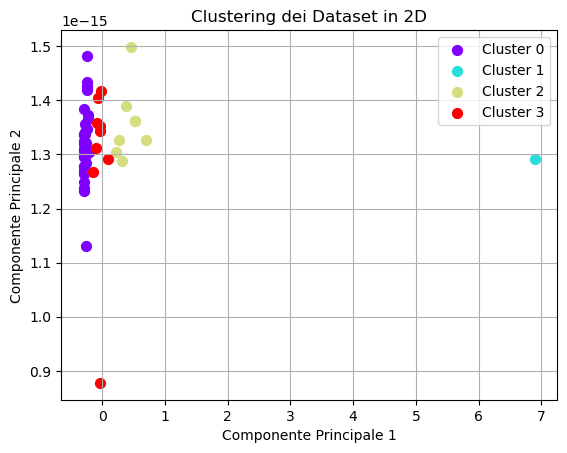

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Tokenizzazione delle stringhe e creazione di rappresentazioni vettoriali
vectorizer = CountVectorizer()

# Originale
#X = vectorizer.fit_transform(set_features)
# Mix delle due
X = vectorizer.fit_transform(top_terms_strings)

# 1 Calcolo della similarità tra dataset basata sulla similarità del coseno
#similarity_matrix = cosine_similarity(X)

# 2 Calcolo della similarità tra dataset basata su word2vec
# Calcolo della similarità tra i documenti basato su Word2Vec
num_documents = len(top_terms_strings)

# Creazione di una matrice di similarità vuota
similarity_matrix = np.zeros((num_documents, num_documents))

# Calcolo della similarità tra i documenti e costruzione della matrice di similarità
for i, doc1 in enumerate(top_terms_strings):
    for j, doc2 in enumerate(top_terms_strings):
        # Calcola la similarità tra le parole nei documenti
        words1 = doc1.split()
        words2 = doc2.split()

        # Calcola la similarità media tra tutte le coppie di parole
        similarities = [model.get_vecattr(word1, 'count') * model.get_vecattr(word2, 'count') for word1 in words1 for word2 in words2 if model.has_index_for(word1) and model.has_index_for(word2)]
        if similarities:
            similarity_matrix[i, j] = np.mean(similarities)

# Normalizza la matrice di similarità in un intervallo [0, 1]
max_similarity = np.max(similarity_matrix)
if max_similarity > 0:
    similarity_matrix /= max_similarity

# Ora puoi procedere con il clustering e la visualizzazione come prima



num_clusters = len(set(categories))  # Numero di cluster desiderati = numero categorie


#1 Applicazione di DBSCAN per raggruppare i dataset
#eps = 1.2  # Distanza massima tra due campioni per appartenere allo stesso cluster
#min_samples = 2  # Numero minimo di campioni in un vicinato per formare un cluster
#dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#clusters = dbscan.fit_predict(similarity_matrix)

#2 Applicazione di K-Means per raggruppare i dataset
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

#3 Applicazione Clustering gerarchico
# Esempio di clustering gerarchico con 3 cluster
#gerarchic = AgglomerativeClustering(n_clusters=num_clusters)
#clusters = gerarchic.fit_predict(similarity_matrix)


# Visualizzazione del dendrogramma
#from scipy.cluster.hierarchy import linkage

# Calcolo della matrice di collegamento
#linkage_matrix = linkage(similarity_matrix, 'ward')

#Applicazione clustering gerarchico con threshold
#from scipy.cluster.hierarchy import fcluster
# Utilizzo di fcluster per ottenere i cluster a una certa altezza
#threshold = 1.8  # Imposta l'altezza del taglio sul dendrogramma
#clusters = fcluster(linkage_matrix, threshold, criterion='distance')


# Visualizzazione del dendrogramma
#plt.figure(figsize=(10, 7))
#dendrogram(linkage_matrix)
#plt.title('Dendrogramma')
#plt.xlabel('Punti dati')
#plt.ylabel('Distanza')
#plt.show()

# Riduzione dimensionale con PCA a 2 componenti
pca = PCA(n_components=2)
X_pca = pca.fit_transform(similarity_matrix)

# Plot in 2D dei cluster
unique_clusters = np.unique(clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))

for cluster_label, color in zip(unique_clusters, colors):
    cluster_mask = (clusters == cluster_label)
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_label}',
        color=color,
        s=50
    )

# Impostazioni del plot
plt.title('Clustering dei Dataset in 2D')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend()
plt.grid(True)
plt.show()



In [30]:
feat = top_terms_strings

# Organizzazione dei dataset per cluster
dataset_per_cluster = {}
for i, cluster_label in enumerate(clusters):
    if cluster_label not in dataset_per_cluster:
        dataset_per_cluster[cluster_label] = []
    dataset_per_cluster[cluster_label].append(feat[i])

# Visualizzazione dei dataset per ciascun cluster
for cluster_label, datasets in dataset_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    for dataset in datasets:
        #print(f"categoria: {dictionary[dataset]}")
        print(f"features: {dataset}")
    print("-----")

Cluster 3:
features: total regents cohort num pctofcohort
features: leveland num pct level tested
features: preference applications ontime st rd
features: ig diabetes type loss sticky
features: decelerations variability term short light
features: ages both ys years adjusted
features: mean senergy roughness rm fluctuation
features: spectral filename stft crossing bandwidth
features: video views link img info
-----
Cluster 2:
features: percent frl prek fl schoolyear
features: hlth chol phys high check
features: danceability acousticness energy per loudnessd
features: season games noc medal height
features: season games noc medal height
features: driver dob surname forename ref
features: time date fp quali sprint
features: rank ana agi spd flx
-----
Cluster 0:
features: enrolled absent present released dbn
features: project phase name geographic building
features: community nta bin bbl tract
features: numberand street program census community
features: score parent nr prep sport
features:

In [43]:
# Visualizzazione solo categorie
#for cluster_label, datasets in dataset_per_cluster.items():
#    print(f"Cluster {cluster_label}:")
#    for dataset in datasets:
#        print(f"{dictionary[dataset]}", end=' ')
#    print()

## PCA 3D

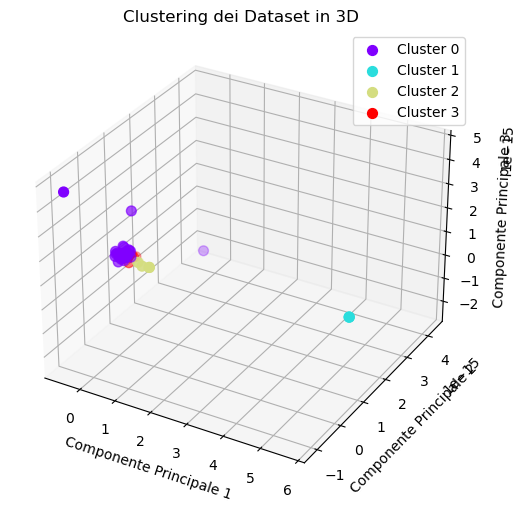

In [17]:
# Riduzione dimensionale con PCA a 3 componenti
pca = PCA(n_components=3)
X_pca = pca.fit_transform(similarity_matrix)

# Plot in 3D dei cluster
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Estrai punti per ciascun cluster
unique_clusters = np.unique(clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))

for cluster_label, color in zip(unique_clusters, colors):
    cluster_mask = (clusters == cluster_label)
    ax.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        X_pca[cluster_mask, 2],
        label=f'Cluster {cluster_label}',
        color=color,
        s=50
    )

# Impostazioni del plot
ax.set_title('Clustering dei Dataset in 3D')
ax.set_xlabel('Componente Principale 1')
ax.set_ylabel('Componente Principale 2')
ax.set_zlabel('Componente Principale 3')
ax.legend()
plt.show()